This notebook fits a BiLSTM for Twitter Corpus.


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from sklearn.preprocessing import LabelBinarizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize,sent_tokenize
import re,string,unicodedata
from keras.preprocessing import text, sequence
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.model_selection import train_test_split
from string import punctuation
import keras
from keras.models import Sequential
from keras.layers import Dense,Embedding,LSTM,Dropout,Bidirectional,GRU
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [3]:
EMBEDDING_FILE = '../datasets/glove.twitter.27B.200d.txt'

In [4]:
# Suppose `texts` is a list of sentences.
data = pd.read_json("../dataset/Sarcasm_Headlines_Dataset.json", lines=True)
data = data.sample(n=1000)

In [5]:
texts = data["headline"].tolist()
labels = data["is_sarcastic"].values

In [6]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

# Use a fixed value for `maxlen` based on your data's requirements
maxlen = 200  # for example
data = pad_sequences(sequences, maxlen=maxlen)

# Convert the labels to a numpy array
labels = np.array(labels)


In [7]:
embedding_index = {}
with open(EMBEDDING_FILE, 'r', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = coefs


In [8]:
word_index = tokenizer.word_index
embedding_dim = 200 # Size of the GloVe vectors.
vocab_size = len(word_index) + 1  # Adding 1 because index 0 is reserved

embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None:
        # Words not found in the embedding index will be all zeros.
        embedding_matrix[i] = embedding_vector


In [14]:

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, input_length=maxlen, 
                    weights=[embedding_matrix], trainable=False))
model.add(Bidirectional(LSTM(units=64)))
model.add(Dense(1, activation='sigmoid')) 

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 200, 200)          867000    
                                                                 
 bidirectional_1 (Bidirecti  (None, 128)               135680    
 onal)                                                           
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 1002809 (3.83 MB)
Trainable params: 135809 (530.50 KB)
Non-trainable params: 867000 (3.31 MB)
_________________________________________________________________


In [15]:


history = model.fit(data,labels, batch_size=128, epochs=9, validation_split=0.25)


Epoch 1/9
6/6 [==============================] - 9s 1s/step - loss: 0.7012 - accuracy: 0.4867 - val_loss: 0.6697 - val_accuracy: 0.5600
Epoch 2/9
6/6 [==============================] - 6s 1s/step - loss: 0.6595 - accuracy: 0.5813 - val_loss: 0.6495 - val_accuracy: 0.5960
Epoch 3/9
6/6 [==============================] - 7s 1s/step - loss: 0.6338 - accuracy: 0.6347 - val_loss: 0.6263 - val_accuracy: 0.6720
Epoch 4/9
6/6 [==============================] - 6s 1s/step - loss: 0.6046 - accuracy: 0.7280 - val_loss: 0.5960 - val_accuracy: 0.7440
Epoch 5/9
6/6 [==============================] - 6s 1s/step - loss: 0.5640 - accuracy: 0.7560 - val_loss: 0.5515 - val_accuracy: 0.7640
Epoch 6/9
6/6 [==============================] - 7s 1s/step - loss: 0.5045 - accuracy: 0.7987 - val_loss: 0.4982 - val_accuracy: 0.7880
Epoch 7/9
6/6 [==============================] - 6s 1s/step - loss: 0.4436 - accuracy: 0.8133 - val_loss: 0.4673 - val_accuracy: 0.7960
Epoch 8/9
6/6 [==============================] -

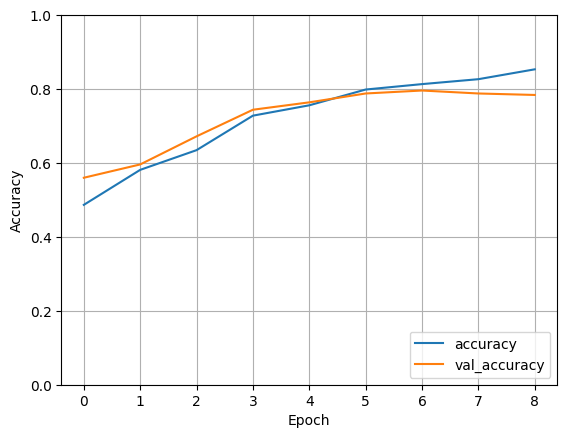

In [20]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.grid()
plt.show()

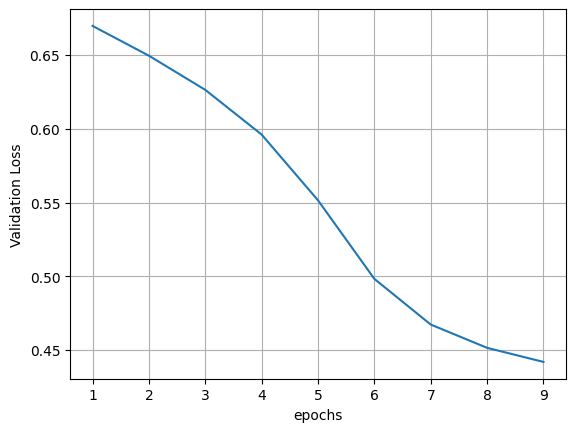

In [22]:
losses = history.history["val_loss"]
plt.plot(range(1,10), losses)
plt.xlabel("epochs")
plt.ylabel("Validation Loss")
plt.grid()
plt.show()

Accuracy: 80%